In [1]:
# Cell 1: Imports
import sys
sys.path.append('..')

import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import random
from PIL import Image

from src.models.model import create_model
from src.data.preprocessing import DataAugmentation
from src.explainability.gradcam import visualize_gradcam, GradCAM, get_target_layer

print("✅ All imports successful!")


✅ All imports successful!


In [2]:

# Cell 2: Load Trained Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# Model configuration
MODEL_NAME = 'resnet50'
NUM_CLASSES = 4
CLASS_NAMES = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
MODEL_PATH = '../models/saved/resnet50_best.pth'

# Create model
model = create_model(MODEL_NAME, num_classes=NUM_CLASSES, pretrained=False)

# Load trained weights
checkpoint = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

print(f"✅ Loaded trained model from: {MODEL_PATH}")
print(f"   Best validation accuracy: {checkpoint['best_val_acc']:.2f}%")



Device: cuda
  Training from scratch
✅ Built resnet50 with 4 output classes
✅ Loaded trained model from: ../models/saved/resnet50_best.pth
   Best validation accuracy: 96.13%


In [3]:
# Cell 3: Get Test Images
from pathlib import Path

TEST_DIR = Path('../data/processed/test')

# Get sample images from each class
sample_images = {}
for class_name in CLASS_NAMES:
    class_dir = TEST_DIR / class_name
    images = list(class_dir.glob('*.png'))
    if images:
        # Pick random samples
        sample_images[class_name] = random.sample(images, min(5, len(images)))

print("Sample images selected:")
for cls, imgs in sample_images.items():
    print(f"  {cls}: {len(imgs)} images")



Sample images selected:
  COVID: 5 images
  Lung_Opacity: 5 images
  Normal: 5 images
  Viral Pneumonia: 5 images


In [4]:
# Cell 4: Create Grad-CAM Visualizations
transform = DataAugmentation.get_val_transform()

print("\nGenerating Grad-CAM visualizations...\n")

all_results = {}

for class_name, image_paths in sample_images.items():
    print(f"Processing {class_name} images...")
    class_results = []
    
    for i, img_path in enumerate(image_paths):
        # Generate Grad-CAM
        results = visualize_gradcam(
            model=model,
            image_path=str(img_path),
            transform=transform,
            device=device,
            class_names=CLASS_NAMES,
            model_name=MODEL_NAME,
            save_path=f'../results/plots/gradcam_{class_name}_{i+1}.png'
        )
        
        class_results.append(results)
        
        # Print prediction
        pred_label = results['predicted_label']
        confidence = results['confidence']
        correct = "✅" if pred_label == class_name else "❌"
        print(f"  Image {i+1}: {pred_label} ({confidence:.2f}%) {correct}")
    
    all_results[class_name] = class_results
    print()

print("✅ Grad-CAM visualizations generated!")




Generating Grad-CAM visualizations...

Processing COVID images...
  Image 1: COVID (100.00%) ✅
  Image 2: COVID (88.25%) ✅
  Image 3: COVID (99.95%) ✅
  Image 4: COVID (100.00%) ✅
  Image 5: COVID (99.99%) ✅

Processing Lung_Opacity images...
  Image 1: Lung_Opacity (87.51%) ✅
  Image 2: Normal (98.80%) ❌
  Image 3: Lung_Opacity (99.97%) ✅
  Image 4: Lung_Opacity (99.66%) ✅
  Image 5: Lung_Opacity (96.38%) ✅

Processing Normal images...
  Image 1: Normal (99.20%) ✅
  Image 2: Normal (79.76%) ✅
  Image 3: Normal (99.97%) ✅
  Image 4: Normal (98.86%) ✅
  Image 5: Normal (98.89%) ✅

Processing Viral Pneumonia images...
  Image 1: Viral Pneumonia (98.38%) ✅
  Image 2: Viral Pneumonia (99.98%) ✅
  Image 3: Viral Pneumonia (99.98%) ✅
  Image 4: Viral Pneumonia (99.97%) ✅
  Image 5: Viral Pneumonia (99.99%) ✅

✅ Grad-CAM visualizations generated!


C:\Users\Asus\AppData\Local\Temp\ipykernel_15300\2283709946.py:36: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Asus\AppData\Local\Temp\ipykernel_15300\2283709946.py:37: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig('../results/plots/gradcam_grid_all_classes.png', dpi=300, bbox_inches='tight')
d:\projects\New folder\mediscan-covid19\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


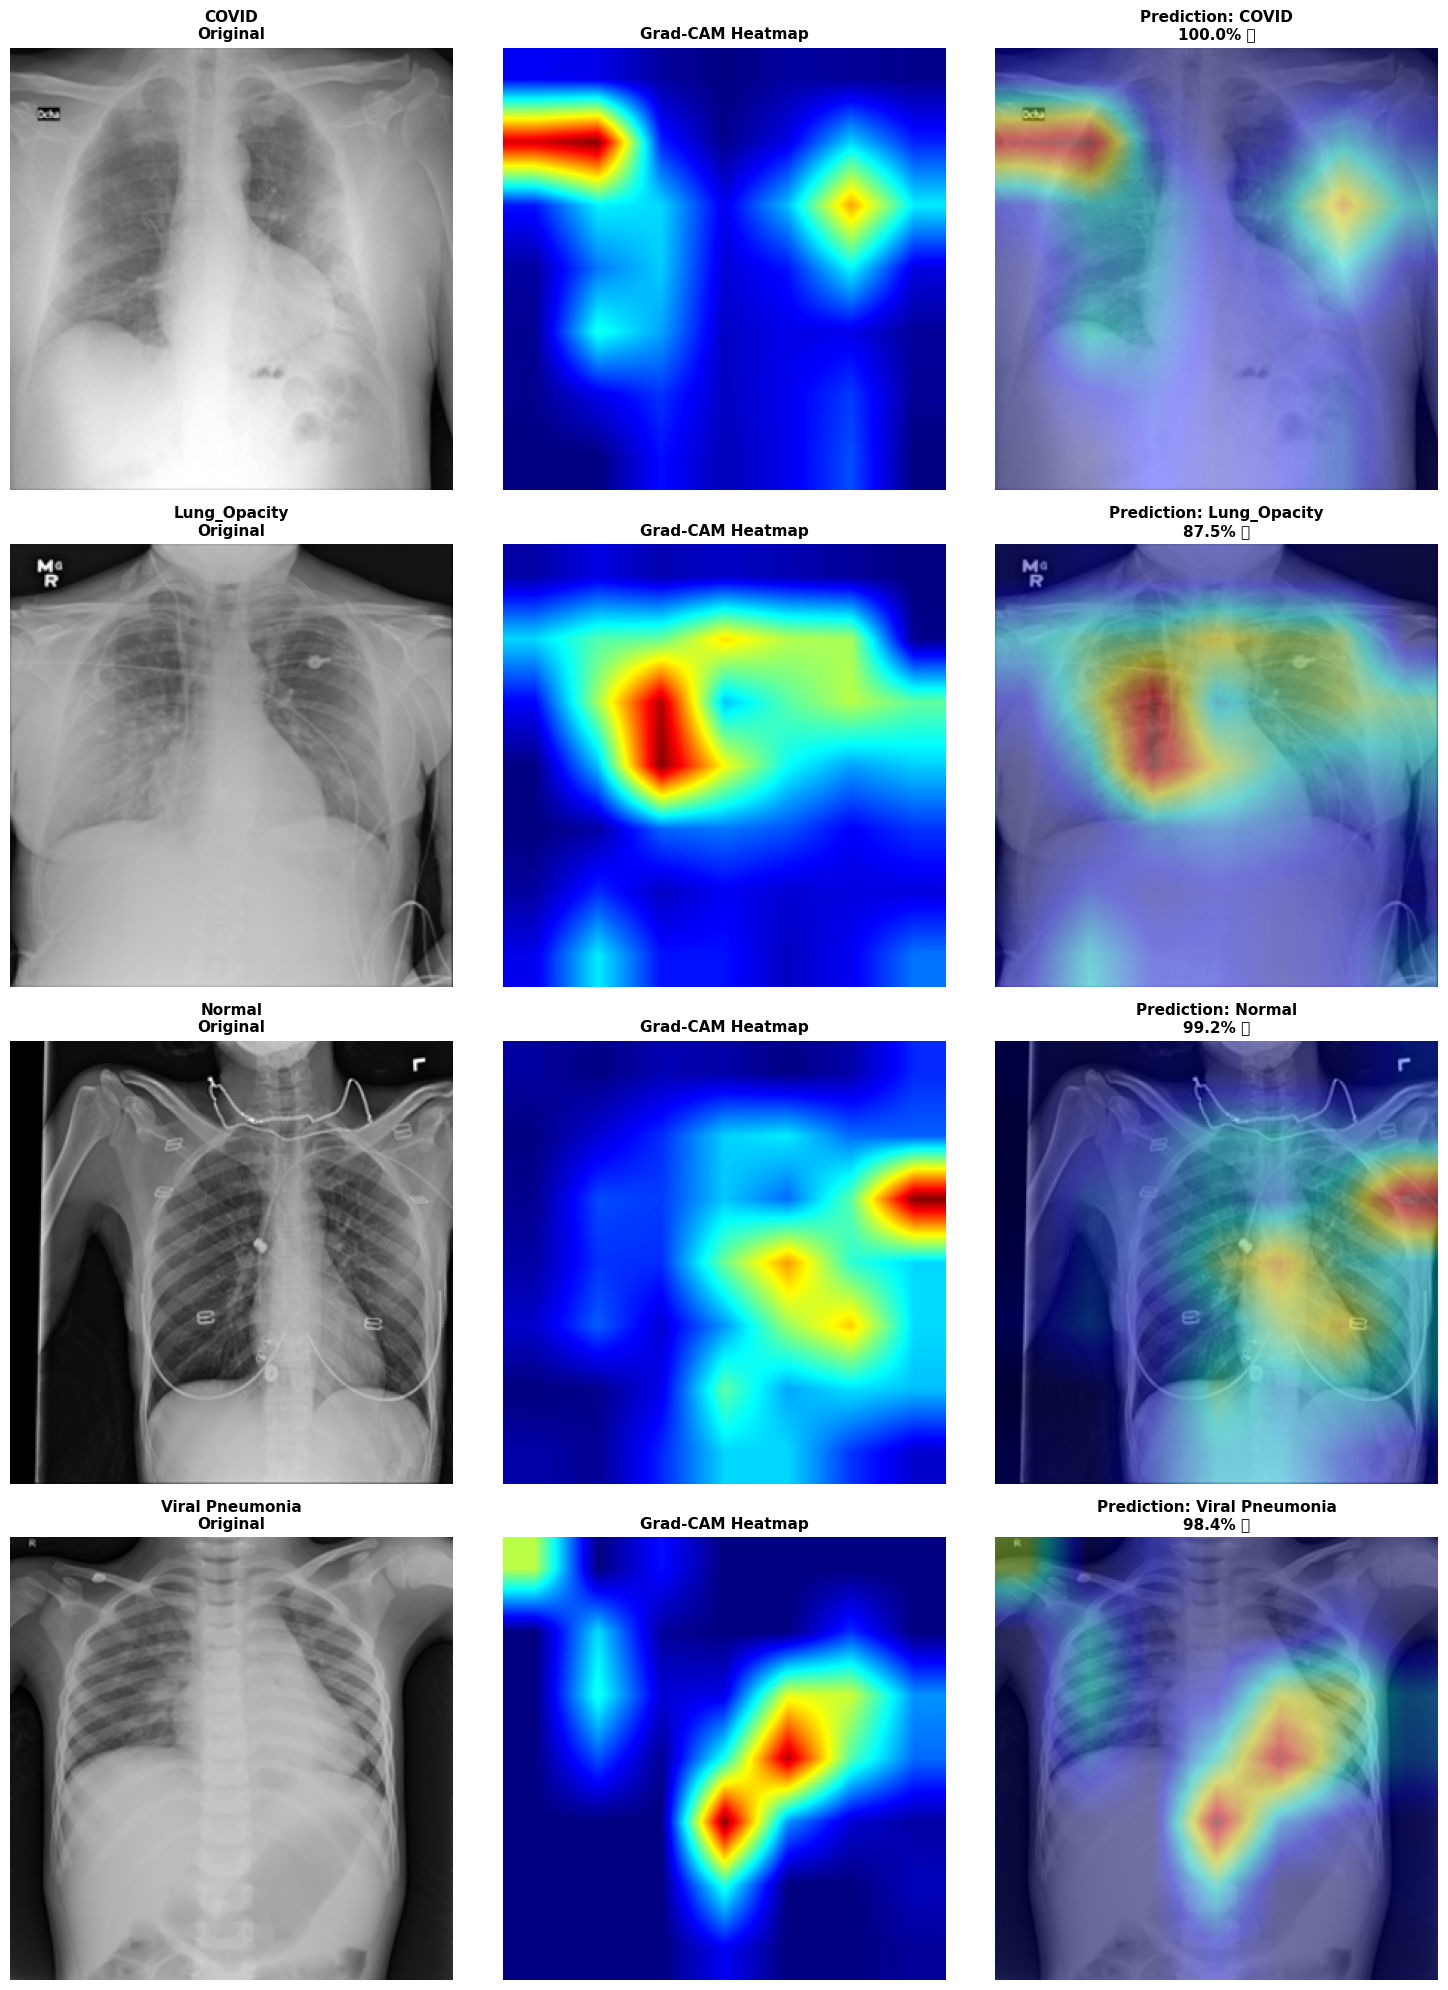

In [5]:
# Cell 5: Display Grid of Results
def plot_gradcam_grid(all_results, max_per_class=3):
    """Plot grid of Grad-CAM results"""
    num_classes = len(all_results)
    
    fig, axes = plt.subplots(num_classes, 3, figsize=(15, num_classes * 5))
    
    if num_classes == 1:
        axes = axes.reshape(1, -1)
    
    for idx, (class_name, results) in enumerate(all_results.items()):
        # Take first image from each class
        result = results[0]
        
        # Original
        axes[idx, 0].imshow(result['original_image'])
        axes[idx, 0].set_title(f'{class_name}\nOriginal', fontsize=11, fontweight='bold')
        axes[idx, 0].axis('off')
        
        # Heatmap
        axes[idx, 1].imshow(result['heatmap'])
        axes[idx, 1].set_title('Grad-CAM Heatmap', fontsize=11, fontweight='bold')
        axes[idx, 1].axis('off')
        
        # Overlay
        axes[idx, 2].imshow(result['overlay'])
        pred_label = result['predicted_label']
        confidence = result['confidence']
        correct = "✅" if pred_label == class_name else "❌"
        axes[idx, 2].set_title(
            f'Prediction: {pred_label}\n{confidence:.1f}% {correct}',
            fontsize=11, fontweight='bold'
        )
        axes[idx, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig('../results/plots/gradcam_grid_all_classes.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_gradcam_grid(all_results)



In [6]:
# Cell 6: Analyze Correct vs Incorrect Predictions
correct_predictions = []
incorrect_predictions = []

for class_name, results in all_results.items():
    for result in results:
        if result['predicted_label'] == class_name:
            correct_predictions.append((class_name, result))
        else:
            incorrect_predictions.append((class_name, result))

print(f"Correct predictions: {len(correct_predictions)}")
print(f"Incorrect predictions: {len(incorrect_predictions)}")



Correct predictions: 19
Incorrect predictions: 1



Analyzing incorrect predictions...



C:\Users\Asus\AppData\Local\Temp\ipykernel_15300\3317838855.py:32: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Asus\AppData\Local\Temp\ipykernel_15300\3317838855.py:33: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.savefig('../results/plots/gradcam_incorrect_predictions.png', dpi=300, bbox_inches='tight')
d:\projects\New folder\mediscan-covid19\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


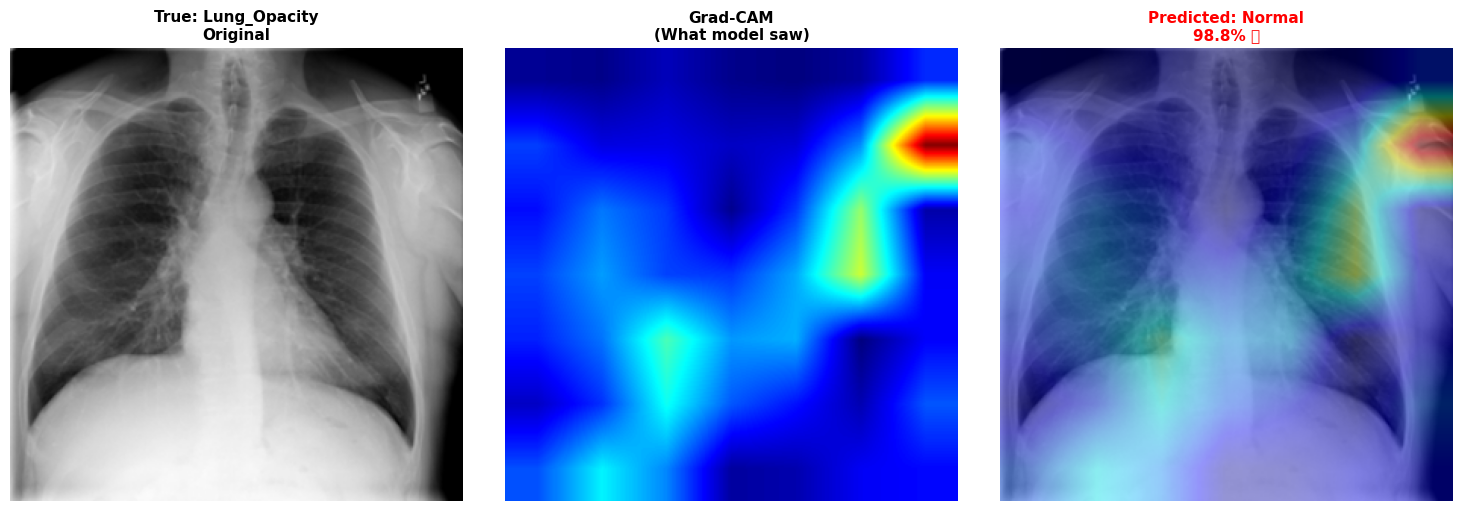

In [7]:
# Cell 7: Visualize Incorrect Predictions (if any)
if len(incorrect_predictions) > 0:
    print("\nAnalyzing incorrect predictions...\n")
    
    fig, axes = plt.subplots(len(incorrect_predictions), 3, figsize=(15, len(incorrect_predictions) * 5))
    
    if len(incorrect_predictions) == 1:
        axes = axes.reshape(1, -1)
    
    for idx, (true_class, result) in enumerate(incorrect_predictions):
        # Original
        axes[idx, 0].imshow(result['original_image'])
        axes[idx, 0].set_title(f'True: {true_class}\nOriginal', fontsize=11, fontweight='bold')
        axes[idx, 0].axis('off')
        
        # Heatmap
        axes[idx, 1].imshow(result['heatmap'])
        axes[idx, 1].set_title('Grad-CAM\n(What model saw)', fontsize=11, fontweight='bold')
        axes[idx, 1].axis('off')
        
        # Overlay
        axes[idx, 2].imshow(result['overlay'])
        pred = result['predicted_label']
        conf = result['confidence']
        axes[idx, 2].set_title(
            f'Predicted: {pred}\n{conf:.1f}% ❌',
            fontsize=11, fontweight='bold',
            color='red'
        )
        axes[idx, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig('../results/plots/gradcam_incorrect_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("✅ All predictions were correct in this sample!")


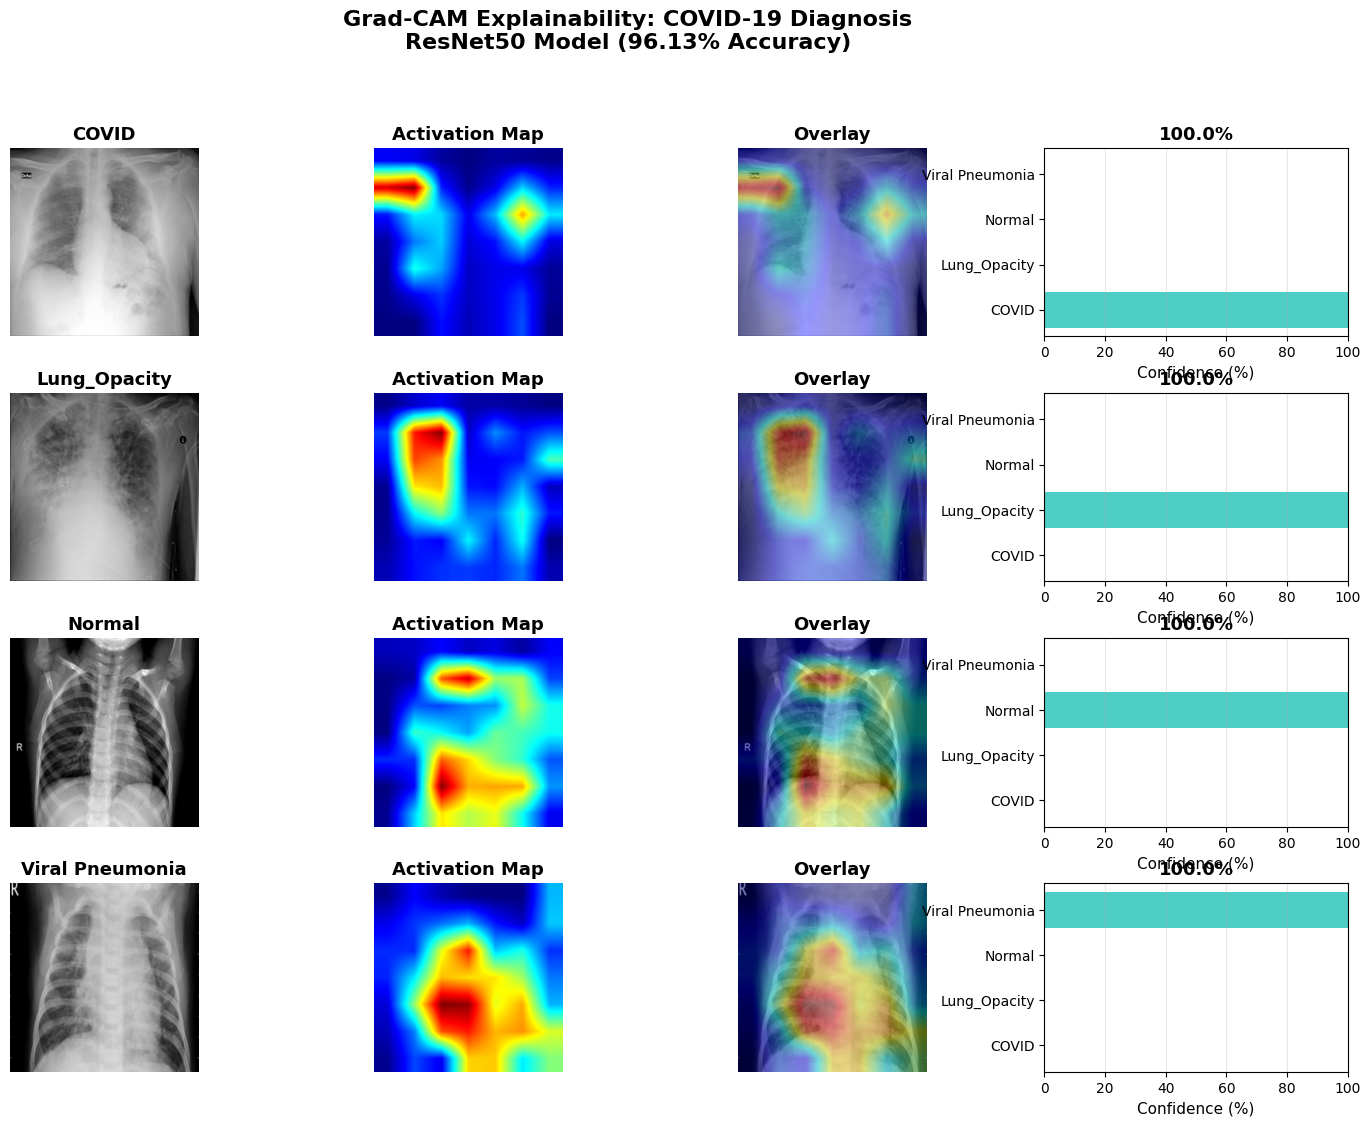

In [8]:

# Cell 8: Create Publication-Quality Figure
def create_publication_figure(all_results):
    """Create a publication-quality figure showing best examples"""
    
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.2)
    
    row = 0
    for class_name, results in all_results.items():
        # Take best example (highest confidence correct prediction)
        correct = [r for r in results if r['predicted_label'] == class_name]
        if not correct:
            continue
        
        best = max(correct, key=lambda x: x['confidence'])
        
        # Original
        ax1 = fig.add_subplot(gs[row, 0])
        ax1.imshow(best['original_image'])
        ax1.set_title(f'{class_name}', fontsize=13, fontweight='bold')
        ax1.axis('off')
        
        # Heatmap
        ax2 = fig.add_subplot(gs[row, 1])
        ax2.imshow(best['heatmap'])
        ax2.set_title('Activation Map', fontsize=13, fontweight='bold')
        ax2.axis('off')
        
        # Overlay
        ax3 = fig.add_subplot(gs[row, 2])
        ax3.imshow(best['overlay'])
        ax3.set_title('Overlay', fontsize=13, fontweight='bold')
        ax3.axis('off')
        
        # Confidence bar
        ax4 = fig.add_subplot(gs[row, 3])
        classes_conf = [0] * len(CLASS_NAMES)
        classes_conf[CLASS_NAMES.index(class_name)] = best['confidence']
        ax4.barh(CLASS_NAMES, classes_conf, color='#4ECDC4')
        ax4.set_xlim(0, 100)
        ax4.set_xlabel('Confidence (%)', fontsize=11)
        ax4.set_title(f'{best["confidence"]:.1f}%', fontsize=13, fontweight='bold')
        ax4.grid(axis='x', alpha=0.3)
        
        row += 1
    
    fig.suptitle('Grad-CAM Explainability: COVID-19 Diagnosis\nResNet50 Model (96.13% Accuracy)',
                 fontsize=16, fontweight='bold', y=0.995)
    
    plt.savefig('../results/plots/gradcam_publication_figure.png', dpi=300, bbox_inches='tight')
    plt.show()

create_publication_figure(all_results)



In [11]:
# Cell 9: Summary Statistics
print("\n" + "="*70)
print("GRAD-CAM ANALYSIS SUMMARY")
print("="*70)

total_samples = sum(len(results) for results in all_results.values())
total_correct = len(correct_predictions)
accuracy = (total_correct / total_samples) * 100

print(f"\nSample Analysis:")
print(f"  Total samples: {total_samples}")
print(f"  Correct predictions: {total_correct}")
print(f"  Incorrect predictions: {len(incorrect_predictions)}")
print(f"  Sample accuracy: {accuracy:.2f}%")

print(f"\nPer-class Performance:")
for class_name, results in all_results.items():
    correct_class = sum(1 for r in results if r['predicted_label'] == class_name)
    total_class = len(results)
    acc_class = (correct_class / total_class) * 100 if total_class > 0 else 0
    print(f"  {class_name:20} : {correct_class}/{total_class} ({acc_class:.1f}%)")

print("\n" + "="*70)
print("Grad-CAM analysis complete!")

print("="*70)


GRAD-CAM ANALYSIS SUMMARY

Sample Analysis:
  Total samples: 20
  Correct predictions: 19
  Incorrect predictions: 1
  Sample accuracy: 95.00%

Per-class Performance:
  COVID                : 5/5 (100.0%)
  Lung_Opacity         : 4/5 (80.0%)
  Normal               : 5/5 (100.0%)
  Viral Pneumonia      : 5/5 (100.0%)

Grad-CAM analysis complete!
